#  Прогнозирование заказов такси

## Подготовка данных

Откроем файл с данными и изучим их, для этого подключим библиотеку `pandas` помимо неё подключим еще остальные библиотеки, которые нам пригодятся. Для того чтобы прочитать данные из датасета воспользуемся методом `read_csv`, для получения общей информации о датасете воспользуемся методом `info`.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=False)
except:
    data = pd.read_csv('taxi.csv', index_col=False)
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Как видно по данным у нас всего два столбца, пропусков в них нет. Данным по заказам такси вероятно предоставлены за каждые **10** минут, если смотреть по первым 5 строкам из датасета. Переведем тип столбца с датой из **object** в **datetime**:

In [4]:
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Тип у столбца успешно изменили, проверим нет ли в датасете явных дубликатов:

In [5]:
data.duplicated().sum()

0

Неявные дубликаты нет смысла здесь проверять, так как в данных есть только даты и числа. Можно проверить неявные дубликаты в столбце с датами, одни и те же даты могут быть записаны в разном формате, однако, мы ранее смогли преобразовать столбец с датами в нужный нам формат без ошибок, что говорит о том, что все даты записаны в одном формате. Установим дату в качестве индекса датасета, чтобы в дальнейшем мы могли делать выборки по датам:

In [6]:
data = data.set_index('datetime')
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Дата в качестве индекса успешно установилась. Проверим теперь расположены ли данные в хронологическом порядке:

In [7]:
data.index.is_monotonic

True

Данные расположены в хронологическом порядке. По заданию нам необходимо *предсказать количество заказов такси на следующий час*, а в данных у нас указано количество заказов за каждые **10** минут. Сделаем ресемплирование данных по одному часу, для агреации значений будем использовать функцию `sum`, так мы узнаем суммарное количество заказов такси за час.

In [8]:
data_resample = data.resample('1H').sum()
data_resample

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Данные удалось успешно ресемплировались, отсортируем их по дате:

In [9]:
data_resample.sort_values(by='datetime')

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Данные успешно отсортировались, как видно в датасете представлены заказы такси с *1 марта по 31 августа 2018 года*. Можно переходить к анализу данных.

## Анализ данных

Посмотрим информацию о данных с помощью метода `describe`

In [10]:
data_resample.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Максимальное количество заказов за час равно **462**, минимальное количество заказов за час равно **0**. Среднее количество заказов такси за час можно сказать что равно **84**. Посмотрим теперь распределние заказов такси за каждый час на графике:

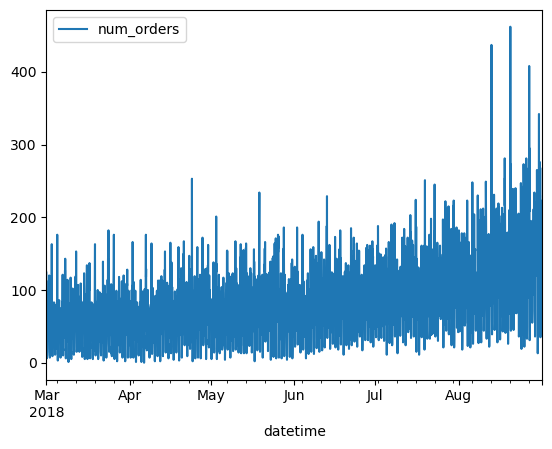

In [11]:
data_resample.plot()
pass

На графике заметно, что в летние месяцы количество заказов начинает расти и достигает максимальных значений в августе, скорее всего это связано с началом и концом периода отпусков у большинства людей. Постороим графика по среднему количеству заказов такси в час по каждому месяцу:

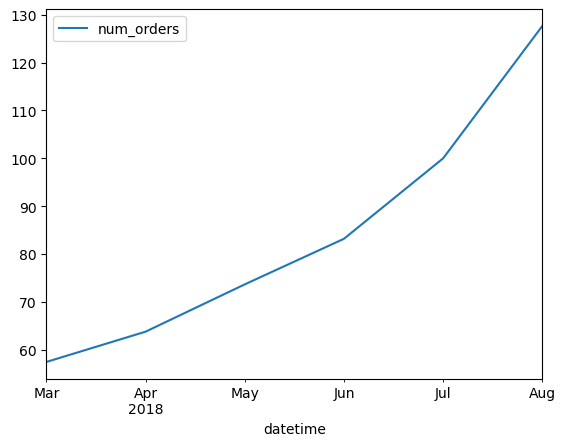

In [12]:
data_resample.resample('1M').mean().plot()
pass

Как видно по графику, среднее количество заказов такси по каждому часу растет каждый месяц и достигает максимального значения в августе. Разложим данные на тренды и сезонность и построим по ним график:

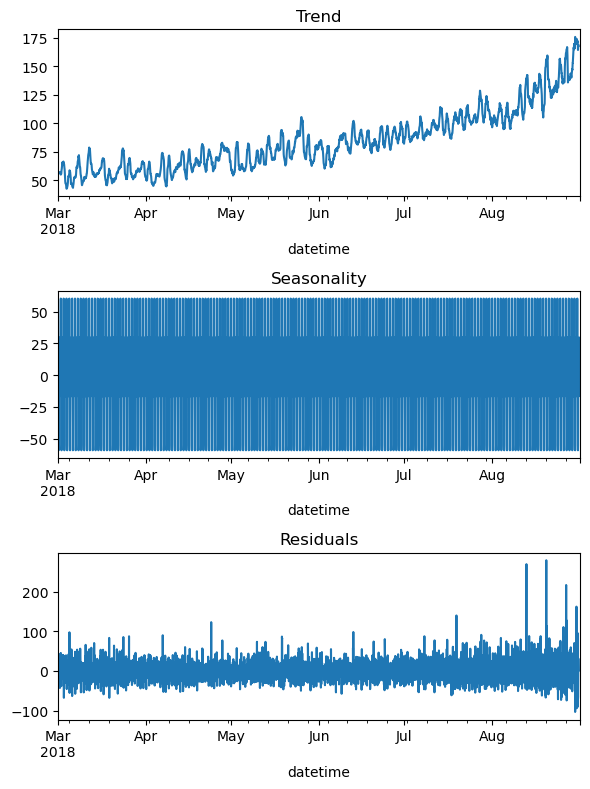

In [13]:
decomposed = seasonal_decompose(data_resample)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

По графику тренда заметно, что тренд на заказ такси постепенно растет, однако, если смотреть на короткие промежутки на графике, видно, что тренд, сначала растет, потом падает, потом тренд снова растет и достигает уже больших значений, чем в прошлый раз, затем снова падает, скорей всего это связано с тем, количество заказов такси может вырасти к концу недели, либо вырастает каждый вечер. График сезонности выглядит непонятно, его тяжело интерпретировать, построим график сезонности на более коротком интервале, например, за две недели:

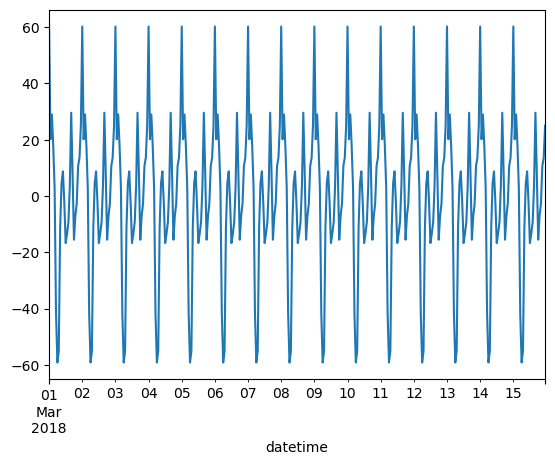

In [14]:
decomposed_seasonal = decomposed.seasonal['2018-03-01':'2018-03-15']
decomposed_seasonal.plot()
pass

Как можно заметить на графике к концу дня всегда вырастает количество заказов такси, а потом резко падает, и так до самого конца графике, как мы и предполагали ранее, количество заказов вырастает в вечернее время, это циклически повторяющиеся
закономерность предоставленного временного ряда. Распрделение ряда со временем не меняется, поэтому его можно сказать, что его стохастический процесс в нем стационарный.

Анализ данных провели, можно переходить к обучению моделей.

## Обучение моделей

Перед тем как переходить к обучению моделей, напишем функцию для создания признаков. Так как число заказов привязано к конкретному времени, то в качестве признаков будем использовать **месяц**, **день**, **день недели**, **час**. В признаках нет года, потому что данные представлены только за один год. В признаке добавлены час, так как ранее мы сделали ресемплирование данных по часу. Также добавим в наши признаки предыдущие значения временного ряда, с помощью них модель сможет понять будут ли значения во временном ряду расти или уменьшатся. В качестве целевого признака будем использовать скользящее среднее по количеству заказов такси, так оно задает задаёт общий тренд временного ряда. Сразу применим функцию для создания признаков. Признаков по предыдущим значениям создадим **24**, как раз по каждому часу за день, размер окна для скользящего среднего укажем такое же.

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    '''
    Функция создает признаки по временному ряду
    '''
    new_data = data.copy()
    new_data['month'] = new_data.index.month
    new_data['day'] = new_data.index.day
    new_data['dayofweek'] = new_data.index.dayofweek
    new_data['hour'] = new_data.index.hour
    
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)

    new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return new_data

In [16]:
data_resample = make_features(data_resample, 24, 24)
data_resample

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,164.875000
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,167.541667
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,168.041667


Разделим данные на обучающую и тестовую выборки, тестовую выборку возьмем **10%** от общей выборки:

In [17]:
train, test = train_test_split(data_resample, shuffle=False, test_size=0.1)
train = train.dropna()
print(train.shape)
print(test.shape)

(3950, 30)
(442, 30)


Данные разделились корректно, разделим теперь их на признаки и целевые признаки:

In [18]:
train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']

test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

Данные успешно разделились, для решения нашей задачи возьмем следующие модели **Линейная регрессия**, **Дерево решений для регрессии**, **Случайный лес для регрессии**. Проверять модели будем по метрике *RMSE*, значение метрики *RMSE* не должно быть больше **48**. Для поиска лучшей модели модели сначала будем использовать кросс-валидацию, так как у нас в данных временной ряд, то для разделения выборок внутри кросс-валидации будем использовать `TimeSeriesSplit`:

In [19]:
model_linear_reg = LinearRegression()
model_tree_reg = DecisionTreeRegressor()
model_forest_reg = RandomForestRegressor()

scores_linear_reg = cross_val_score(model_linear_reg, train_features, train_target, scoring='neg_root_mean_squared_error', 
                                    cv=TimeSeriesSplit().split(train_features))
scores_tree_reg = cross_val_score(model_tree_reg, train_features, train_target, scoring='neg_root_mean_squared_error', 
                                  cv=TimeSeriesSplit().split(train_features))
scores_forest_reg = cross_val_score(model_forest_reg, train_features, train_target, scoring='neg_root_mean_squared_error', 
                                    cv=TimeSeriesSplit().split(train_features))

print('RMSE Кросс-валидация Линейной регрессии', abs(scores_linear_reg.mean()))
print('RMSE Кросс-валидация Дерево решений для регрессии', abs(scores_tree_reg.mean()))
print('RMSE Кросс-валидация Случайного леса для регрессии', abs(scores_forest_reg.mean()))

RMSE Кросс-валидация Линейной регрессии 26.961994085725582
RMSE Кросс-валидация Дерево решений для регрессии 35.34843473897298
RMSE Кросс-валидация Случайного леса для регрессии 25.179390468619303


По итогу кросс-валидации видно, что все модели подходят для решения нашего задания, у всех моделей значение по метрике *RMSE* меньше **48**, самое лучшее значение по данной метрике у модели **Случайный лес для регрессии** — **25.15**, далее идет модель **Линейной регрессии** — **26.96**, самый высокое значение у модели **Дерево решений для регрессии** — **35.30**. Переберем гиперпараметры у моделей **Дерево решений для регрессии**, **Случайный лес для регрессии** с помощью `GridSearchCV` может получиться подобрать модель с более низким значением по метрике *RMSE*. В `GridSearchCV` для разделения данных также будем использовать `TimeSeriesSplit`:

In [20]:
model_tree = DecisionTreeRegressor(random_state=12345)
grid_tree = GridSearchCV(model_tree, param_grid={'max_depth': [1, 30]}, scoring='neg_root_mean_squared_error', 
                         cv=TimeSeriesSplit().split(train_features))
grid_tree.fit(train_features, train_target)
print('Best params', grid_tree.best_params_)
print('Best score RMSE', abs(grid_tree.best_score_))

Best params {'max_depth': 1}
Best score RMSE 34.9830487825128


С помощью `GridSearchCV` мы узнали, что модель **Дерево решений для регрессии** с глубиной деревьев равное **1** достигает лучших значений по метрике *RMSE*  — **34.98**, это значение меньше, чем при кросс-валидации, однако все ещё больше, чем у других моделей. Сделаем теперь перебор гиперпараметров через `GridSearchCV` для модели **Случайный лес для регрессии**:

In [21]:
model_forest = RandomForestRegressor(random_state=12345)
params = {
    'max_depth': [1, 5, 10, 15, 20, 25, 30],
    'n_estimators': [1, 10, 20, 30, 40, 50]
}
grid_forest = GridSearchCV(model_forest, param_grid=params, scoring='neg_root_mean_squared_error', 
                           cv=TimeSeriesSplit().split(train_features))
grid_forest.fit(train_features, train_target)
print('Best params', grid_forest.best_params_)
print('Best score RMSE', abs(grid_forest.best_score_))

Best params {'max_depth': 20, 'n_estimators': 50}
Best score RMSE 25.481980338089958


Лучшая модель **Случайный лес для регрессии** с параметрами количества деревьев равное **20** и с глубиной каждого дерева равное **50**, как и в кросс-валидации, лучшей моделью по метрике *RMSE*, оказалась модель **Случайный лес для регрессии**, значение по метрике равно **25.48**, будем её использовать для предсказаний на тестовой выборке, так как данная модель показала лучший результат по метрике *RMSE* по сравнению с другими моделями.

In [22]:
best_model_forest = grid_forest.best_estimator_
best_model_forest.fit(train_features, train_target)
best_model_forest_predictions = best_model_forest.predict(test_features)
print('RMSE Случайный лес для регрессии', mean_squared_error(test_target, best_model_forest_predictions, squared=False))

RMSE Случайный лес для регрессии 44.41455476611771


Значение метрики *RMSE* у модели **Случайный лес для регрессии** на тестовой выборке равно **44.41**, это меньше **48**, значит модель подходит для решения нашего задания. С учетом выше проведенного обучения различных моделей, для предсказывания количество заказов такси в час, необходимо использовать модель **Случайный лес для регрессии**, у данной модели при обучении было получено самое низкое значение по метрике *RMSE* по сравнению с другими моделями. Проверим теперь модель **Случайный лес для регрессии** на адекватность с помощью `DummyRegressor`, которая будет предсказывать только среднее значение.

In [23]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(train_features, train_target)
prediction_dummy_reg = dummy_regr.predict(test_features)
print('RMSE DummyRegressor на тестовой выборке:', mean_squared_error(test_target, prediction_dummy_reg, squared=False))

RMSE DummyRegressor на тестовой выборке: 84.6499381993622


Метрика *RMSE* у модели, которая предсказывает только среднее значение почти в **2** раза больше, чем у модели **Случайный лес для регрессии**, которая показала самое лучшее значение по метрике *RMSE*, что говорит о том, что модель делает адекватные предсказания. Построим два графика с реальными данными из тестовой выборки и с данными, которая предсказала лучшая модель.

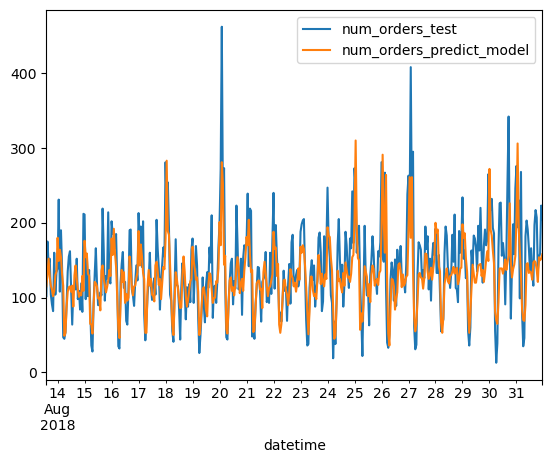

In [24]:
test_and_predict = pd.DataFrame(columns=['num_orders_test', 'num_orders_predict_model'])
test_and_predict['num_orders_test'] = test_target
test_and_predict['num_orders_predict_model'] = best_model_forest_predictions.astype('int')
test_and_predict.plot()
pass

Как можно заметить на графике, предсказанные значения моделью, похожие на реальные значения из тестовой выборки, также можно заметить, что у графиков похожие распределения данных.

### Общий вывод

В рамках задания необходимо было обучить модель, которая предсказывает количество заказов такси на следующий час, для проверки качества моделей необходимо было использовать метрику *RMSE*, значение метрике на тестовой выборке не должно быть больше **48**. Было обучено несколько моделей машинного обучения — **Линейная регрессия**, **Дерево решений для регрессии**, **Случайный лес для регрессии** для обучения моделей использовалась кросс-валидация и `GridSearchCV`, были получены следующие результаты:

Кросс-валидация с метрикой *RMSE*:

- Линейная регрессия — **26.96**;
- Дерево решений для регрессии — **35.30**;
- Случайный лес для регрессии — **25.15**.

GridSearchCV с метрикой *RMSE* лучшие показатели:

- Дерево решений для регрессии — **34.98**;
- Случайный лес для регрессии — **25.48**.

На основании полученных результатов по обучению моделей, была выбрана модель необходимо модель **Случайный лес для регрессии**, на тестовой выборке данная модель показала значение метрике *RMSE* равное **44.41**, что меньше **48**, также  данная модель была проверена на адекватность и с помощью графика было проверено насколько предсказанные значения моделью отличаются от реальных.

На основании вышеизложенного для предсказания количество заказов такси в час необходимо использовать модель **Случайный лес для регрессии**.